In [ ]:
import glob
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import os #loading file path
import torch
import pandas as pd
import spacy #tokenizer
from torch.nn.utils.rnn import pad_sequence #pad patch 
from torch.utils.data import DataLoader,Dataset
from PIL import Image #Load image
from torchvision import transforms
import nltk


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""import requests
file_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
r = requests.get(file_url, stream = True)

with open("/content/drive/My Drive/Colab Notebooks/DL_3/Q1/Flickr8k_Dataset.zip", "wb") as file:
	for block in r.iter_content(chunk_size = 1024):
		if block:
			file.write(block)"""


'import requests\nfile_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"\nr = requests.get(file_url, stream = True)\n\nwith open("/content/drive/My Drive/Colab Notebooks/DL_3/Q1/Flickr8k_Dataset.zip", "wb") as file:\n\tfor block in r.iter_content(chunk_size = 1024):\n\t\tif block:\n\t\t\tfile.write(block)'

In [ ]:
#!unzip "/content/drive/My Drive/Colab Notebooks/DL_3/Q1/Flickr8k_Dataset.zip" -d "/content/drive/My Drive/Colab Notebooks/DL_3/Q1/Flickr8k_Dataset"

In [ ]:
from nltk import word_tokenize
spacy_eng = spacy.load("en")

text = "This is a test for tokenizer"
#lower_text = text.lower()
#[token.text.lower() for token in spacy_eng.tokenizer(text)]
text_words = word_tokenize(text.lower())
print(text_words)

['this', 'is', 'a', 'test', 'for', 'tokenizer']


In [ ]:
class Vocabulary:

  def __init__(self , threshold):
    
    self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
    self.threshold = threshold
    

  def __len__(self):
      return len(self.itos)
    

  @staticmethod
  def tokenizer(text):
        #return [token.text.lower() for token in spacy_eng.tokenizer(text)]
        return  word_tokenize(text.lower())
 

  def vocab_maker(self ,sentences): #list of words that repeate over threshold
        check_word = {}
        index = 4

        for sentence in sentences: #each sentence in sentence list
          for word in self.tokenizer(sentence):
            
                if word in check_word:
                    check_word[word] += 1
                else :
                    check_word[word] = 1

                if check_word[word] == self.threshold:
                    self.itos[index] = word
                    self.stoi[word] = index
                    index += 1

      
  def convert_to_num(self , text):

        tokenised = self.tokenizer(text)
        return [
              self.stoi[token] 
              if token in self.stoi 
              else self.stoi['<UNK>'] 
              for token in tokenised 
        ]



In [ ]:


#testing the vicab class 
v = Vocabulary(threshold=2)
v.vocab_maker(["This is a test for Vocabulary class " ,"and This is a test for Vocabulary"])
print(v.stoi)
print(v.itos)
print(v.convert_to_num("This is a test for Vocabulary class and This is a test for Vocabulary."))



{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'test': 7, 'for': 8, 'vocabulary': 9}
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'this', 5: 'is', 6: 'a', 7: 'test', 8: 'for', 9: 'vocabulary'}
[4, 5, 6, 7, 8, 9, 3, 3, 4, 5, 6, 7, 8, 9, 3]


In [ ]:
class FlickerDatast(Dataset):

  def __init__(self ,root_dir ,csv_file ,transform = None ,threshold = 5):
      
      self.root_dir = root_dir
      self.caption_frame = pd.read_csv(csv_file)
      self.transform = transform
      self.threshold = threshold

      #name of image and caption from dataframe
      self.imgs = self.caption_frame["image"]
      self.captions = self.caption_frame["caption"]

      self.vocab = Vocabulary(threshold)
      self.vocab.vocab_maker(self.captions.tolist())

  def __len__(self):
      return(len(self.caption_frame))

  def __getitem__(self,idx):

      if torch.is_tensor(idx):
            idx = idx.tolist()

      caption = self.captions[idx]
      image_id = self.imgs[idx]
      dir = os.path.join(self.root_dir,image_id)
      #img = cv2.cvtColor(cv2.imread(dir), cv2.COLOR_BGR2RGB)
      img = Image.open(dir).convert("RGB")

      if self.transform is not None:
        img = self.transform(img)


      caption_num = [self.vocab.stoi["<SOS>"]]
      caption_num += self.vocab.convert_to_num(caption)
      caption_num.append(self.vocab.stoi["<EOS>"])

      return img, torch.tensor(caption_num)

      #sample = {'image': img, 'caption': caption}

      #return sample

In [ ]:
dataset = FlickerDatast(csv_file='/content/drive/My Drive/Colab Notebooks/DL_3/Q1/captions.txt',
                                    root_dir='/content/drive/My Drive/Colab Notebooks/DL_3/Q1/Flickr8k_Dataset/Flicker8k_Dataset/',
                                    transform=transforms.Compose([
                                                          transforms.Resize((224, 224)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                                                          )]))



In [ ]:
v.stoi

{'<EOS>': 2,
 '<PAD>': 0,
 '<SOS>': 1,
 '<UNK>': 3,
 'a': 6,
 'for': 8,
 'is': 5,
 'test': 7,
 'this': 4,
 'vocabulary': 9}

In [ ]:
# Creating data indices for training and validation splits: 
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887
test_split = 0.05
shuffle_dataset = True
from torch.utils.data.sampler import SubsetRandomSampler
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(42)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)


In [ ]:
def imshow(image , caption):

    
    cap =  [dataset.vocab.itos[i] for i in caption.tolist()]
    eos_index = cap.index('<EOS>')
    cap = cap[1:eos_index]
    #cap = cap[1:]
    cap = ' '.join(cap) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = image.permute(1,2,0)
    inp = std * inp.numpy() + mean
    inp = np.clip(inp, 0, 1)
    return cap , inp


0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


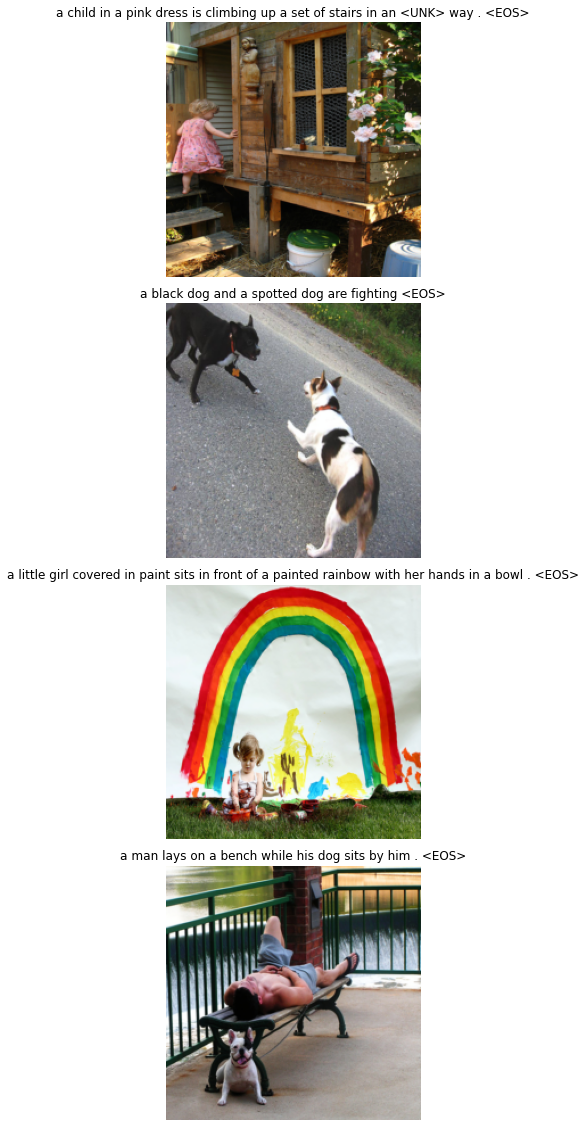

In [ ]:
fig = plt.figure(figsize=(16,16))


for i in range(0 ,len(dataset) ,5):
    image , caption = dataset[i]

    print(i%4, image.shape)

    ax = plt.subplot(4,1 , i%4 + 1)
    plt.tight_layout()

    cap , img  = imshow(image,caption)
    ax.set_title(cap)
    ax.axis('off')
    plt.imshow(img)

    if i == 15:
        plt.show()
        break

In [ ]:
"""def collate_fn(batch , idx):

    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs,dim=0)
          
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets , padding_value=idx)
    return imgs,targets
"""

In [ ]:
class Collate_fn:

    def __init__(self , idx , batch_first):

        self.idx = idx
        self.batch_first = batch_first
    def __call__(self,batch):

        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets , padding_value=self.idx , batch_first = self.batch_first )
        return imgs,targets

In [ ]:
dataloader = DataLoader(dataset, 
                        batch_size = 16,
                        shuffle = True, 
                        num_workers = 0,
                        collate_fn = Collate_fn(idx=dataset.vocab.stoi["<PAD>"],batch_first=True),
                        )

In [ ]:
trainloader = DataLoader(dataset, 
                        batch_size = 16,
                        sampler=train_sampler,
                        #shuffle = True, 
                        num_workers = 4,
                        pin_memory = True,
                        collate_fn = Collate_fn(idx=dataset.vocab.stoi["<PAD>"],batch_first=True),
                        )

testloader = DataLoader(dataset, 
                        batch_size = 1,
                        sampler=test_sampler,
                        #shuffle = True, 
                        num_workers = 4,
                        pin_memory = True,
                        collate_fn = Collate_fn(idx=dataset.vocab.stoi["<PAD>"],batch_first=True),
                        )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


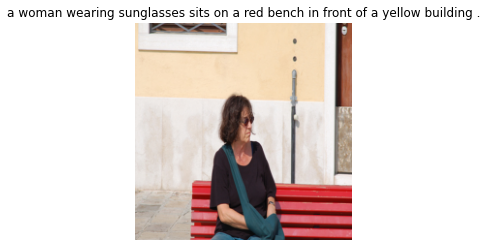

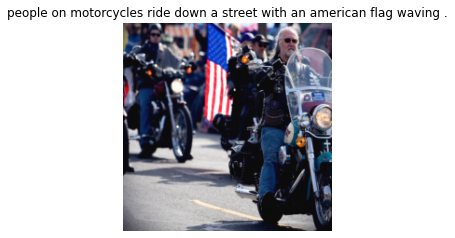

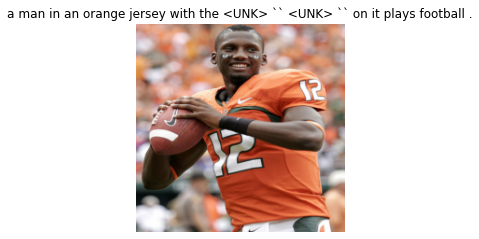

In [ ]:

dataiter = iter(trainloader)


#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(3):
    fig = plt.figure(figsize=(10 , 10))
    image , caption  = images[i],captions[i]
    cap , img = imshow(image , caption)
    
    #show mag
    ax = plt.subplot(1,3, i + 1)
    ax.imshow(img)          
    plt.tight_layout()
    ax.set_title(cap)
    ax.axis('off')           
    #show_image(img,caption_label)
    plt.show()

# **transfer learning**

# Resnet fixing **layers**

In [ ]:
#
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class Encoder(nn.Module):   #Cnn
    def __init__(self, embed_size):

        super(Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = F.relu(features)
        return features

class Decoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_size,vocab_size)
        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        #embeddin layer for captions
        embeds = self.embedding(captions[:,:-1])  #ignore last dimention for cancating with features
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.linear(x)
        return x
    
            
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def captionig(self, image, vocabulary, max_length=20):
        caption_prediction = []

        with torch.no_grad():
            input_data = self.encoder(image).unsqueeze(0)
            states = None #(Hn,Cn)

            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(input_data, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted_index = output.argmax(1)
                input_data = self.decoder.embedding(predicted_index).unsqueeze(0)
                caption_prediction.append(predicted_index.item())

                if vocabulary.itos[predicted_index.item()] == "<EOS>":
                    break
        return torch.tensor(caption_prediction)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
embed_size = 300
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 1e-4

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
for param in model.encoder.resnet.parameters():
    param.requires_grad = False
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

for idx, (image, captions) in enumerate(iter(trainloader)):
  print("1",captions )
  print("\n")
  print("2",captions[:,:-1])

In [ ]:
loss_data = []

for epoch in range(20): 
    running_loss = 0.0  
    for i, (image, captions) in enumerate(iter(trainloader)):
        model.train()
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        running_loss += loss.item()

        #scheduler.step()
    
    loss_data.append(running_loss/i)    
    print('epoch %d : loss: %.3f ' %(epoch + 1, running_loss/i ))
            
            


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 : loss: 3.440 
epoch 2 : loss: 3.119 
epoch 3 : loss: 2.949 
epoch 4 : loss: 2.826 
epoch 5 : loss: 2.737 
epoch 6 : loss: 2.662 
epoch 7 : loss: 2.600 
epoch 8 : loss: 2.546 
epoch 9 : loss: 2.498 
epoch 10 : loss: 2.456 
epoch 11 : loss: 2.418 
epoch 12 : loss: 2.383 
epoch 13 : loss: 2.351 
epoch 14 : loss: 2.321 
epoch 15 : loss: 2.292 
epoch 16 : loss: 2.265 
epoch 17 : loss: 2.242 
epoch 18 : loss: 2.216 
epoch 19 : loss: 2.192 
epoch 20 : loss: 2.171 


In [ ]:
loss_data = [3.440 ,3.119 ,2.949,2.826,2.737,2.662,2.600,2.546,2.498,2.456,2.418,2.383,2.351,2.321,2.292,2.265,2.242,2.216,2.192,2.171]

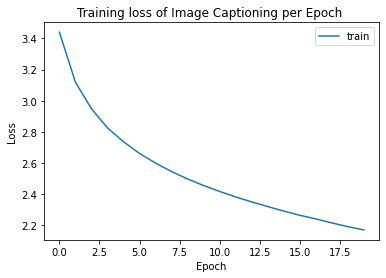

In [ ]:
plt.plot(loss_data )
plt.title('Training loss of Image Captioning per Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train']);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


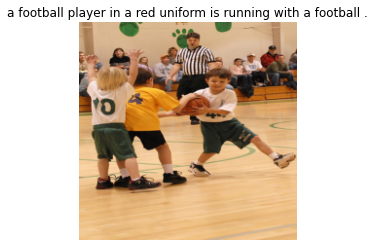

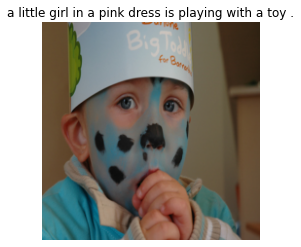

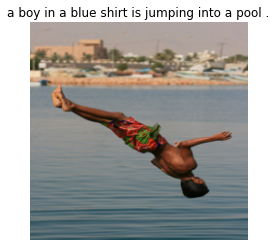

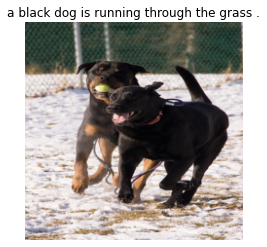

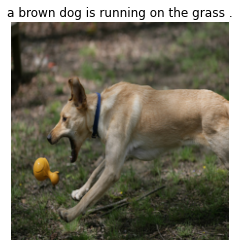

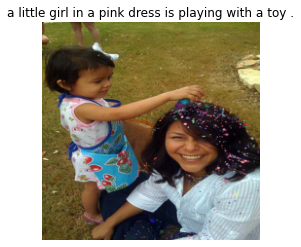

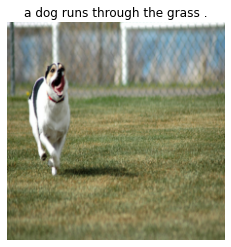

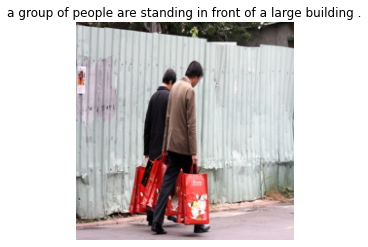

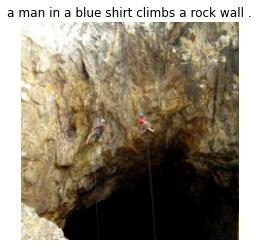

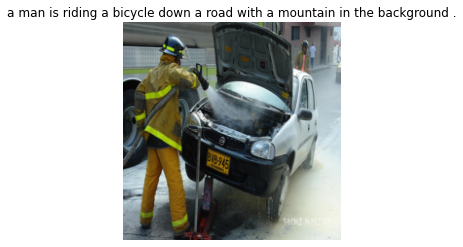

In [ ]:
  for i, (image, captions) in enumerate(iter(testloader)):
    if i <10:
        image,_ = image.to(device),captions.to(device)

        #features = model.encoder(img.to(device))
        #caps = model.captionig(features.unsqueeze(0), vocabulary = dataset.vocab)

        caps = model.captionig(image.to(device), vocabulary = dataset.vocab)
        #caption = ' '.join(caps)
        cap_p ,img_p = imshow(image[0].cpu(), caps)
        plt.imshow(img_p)
        if cap_p is not None:
          plt.title(cap_p)
        plt.axis('off')
        plt.pause(0.001)  # pause a bit so that plots are updated

# Resnet Trainig layers

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
loss_data_2 = []

for epoch in range(20): 
    running_loss = 0.0  
    for i, (image, captions) in enumerate(iter(trainloader)):
        model.train()
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        running_loss += loss.item()

        #scheduler.step()
    
    loss_data_2.append(running_loss/i)    
    print('epoch %d : loss: %.3f ' %(epoch + 1, running_loss/i ))
            
            


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 : loss: 3.867 
epoch 2 : loss: 3.196 
epoch 3 : loss: 2.958 
epoch 4 : loss: 2.802 
epoch 5 : loss: 2.688 
epoch 6 : loss: 2.597 
epoch 7 : loss: 2.521 
epoch 8 : loss: 2.456 
epoch 9 : loss: 2.397 
epoch 10 : loss: 2.346 
epoch 11 : loss: 2.298 
epoch 12 : loss: 2.255 
epoch 13 : loss: 2.215 
epoch 14 : loss: 2.177 
epoch 15 : loss: 2.140 
epoch 16 : loss: 2.108 
epoch 17 : loss: 2.075 
epoch 18 : loss: 2.044 
epoch 19 : loss: 2.016 
epoch 20 : loss: 1.987 


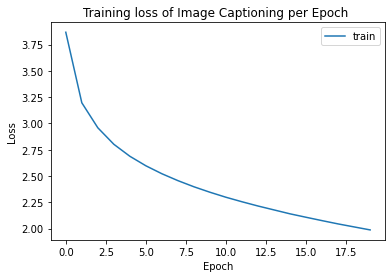

In [ ]:
plt.plot(loss_data_2 )
plt.title('Training loss of Image Captioning per Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train']);

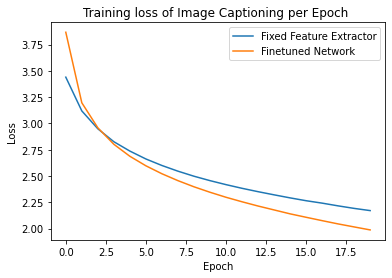

In [ ]:
plt.plot(loss_data )
plt.plot(loss_data_2 )
plt.title('Training loss of Image Captioning per Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Fixed Feature Extractor','Finetuned Network']);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


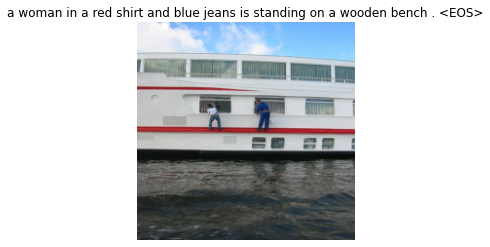

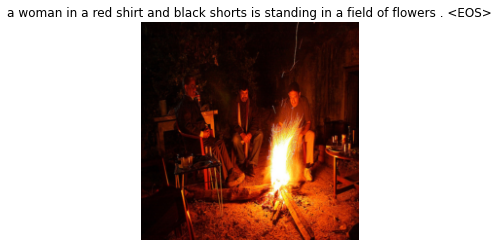

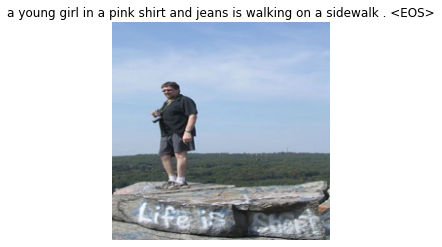

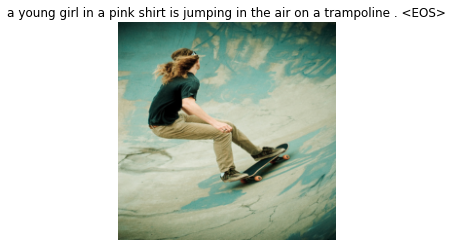

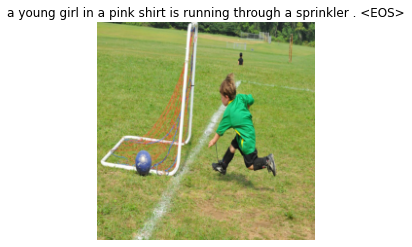

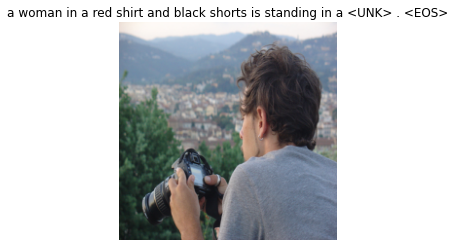

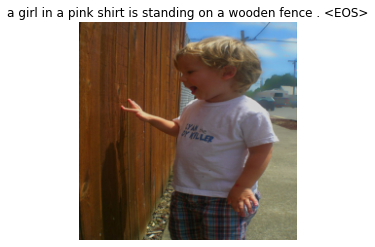

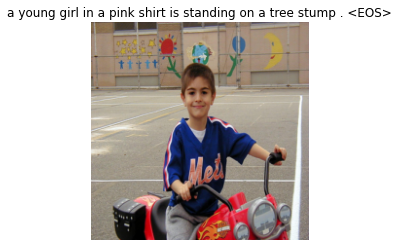

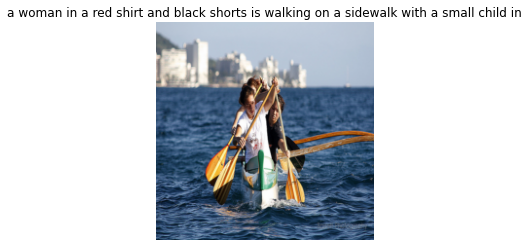

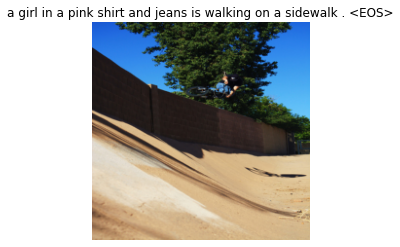

In [ ]:
  for i, (image, captions) in enumerate(iter(testloader)):
    if i <10:
        image,_ = image.to(device),captions.to(device)

        #features = model.encoder(img.to(device))
        #caps = model.captionig(features.unsqueeze(0), vocabulary = dataset.vocab)

        caps = model.captionig(image.to(device), vocabulary = dataset.vocab)
        #caption = ' '.join(caps)
        cap_p ,img_p = imshow(image[0].cpu(), caps)
        plt.imshow(img_p)
        if cap_p is not None:
          plt.title(cap_p)
        plt.axis('off')
        plt.pause(0.001)  # pause a bit so that plots are updated

# nomre ezafi

# Resnet fixing layers +bidirectal LSTM

In [ ]:
#####################################################################
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class Encoder(nn.Module):   #Cnn
    def __init__(self, embed_size):

        super(Encoder, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = F.relu(features)
        return features

class Decoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,bidirectional=True,batch_first=True)
        self.linear = nn.Linear(hidden_size*2,vocab_size)
        self.dropout = nn.Dropout(drop_prob)
     
    def forward(self, features, captions):
        
        #embeddin layer for captions
        embeds = self.embedding(captions[:,:-1])  #ignore last dimention for cancating with features
        
        #concat the features and captions
        x = torch.cat((features.unsqueeze(1),embeds),dim=1) 
        x,_ = self.lstm(x)
        x = self.linear(x)
        return x
    
            
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers=1,drop_prob=0.3):
        super().__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def captionig(self, image, vocabulary, max_length=40):
        caption_prediction = []

        with torch.no_grad():
            input_data = self.encoder(image).unsqueeze(0)
            states = None #(Hn,Cn)

            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(input_data, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted_index = output.argmax(1)
                input_data = self.decoder.embedding(predicted_index).unsqueeze(0)
                caption_prediction.append(predicted_index.item())

                if vocabulary.itos[predicted_index.item()] == "<EOS>":
                    break
        return torch.tensor(caption_prediction)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
embed_size = 300
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 1e-4

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
for param in model.encoder.resnet.parameters():
    param.requires_grad = False
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
loss_data_3 = []

for epoch in range(20): 
    running_loss = 0.0  
    for i, (image, captions) in enumerate(iter(trainloader)):
        model.train()
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        running_loss += loss.item()

        #scheduler.step()
    
    loss_data_3.append(running_loss/i)    
    print('epoch %d : loss: %.3f ' %(epoch + 1, running_loss/i ))
            
            


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 : loss: 2.376 
epoch 2 : loss: 0.907 
epoch 3 : loss: 0.485 
epoch 4 : loss: 0.276 
epoch 5 : loss: 0.160 
epoch 6 : loss: 0.092 
epoch 7 : loss: 0.051 
epoch 8 : loss: 0.027 
epoch 9 : loss: 0.014 
epoch 10 : loss: 0.007 
epoch 11 : loss: 0.004 
epoch 12 : loss: 0.002 
epoch 13 : loss: 0.001 
epoch 14 : loss: 0.001 
epoch 15 : loss: 0.000 
epoch 16 : loss: 0.000 
epoch 17 : loss: 0.000 
epoch 18 : loss: 0.000 
epoch 19 : loss: 0.000 
epoch 20 : loss: 0.000 


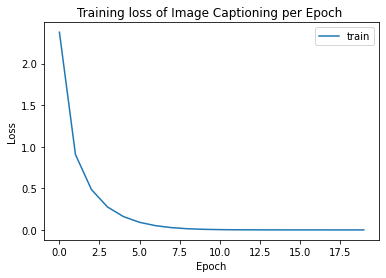

In [ ]:
plt.plot(loss_data_3 )
plt.title('Training loss of Image Captioning per Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train']);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


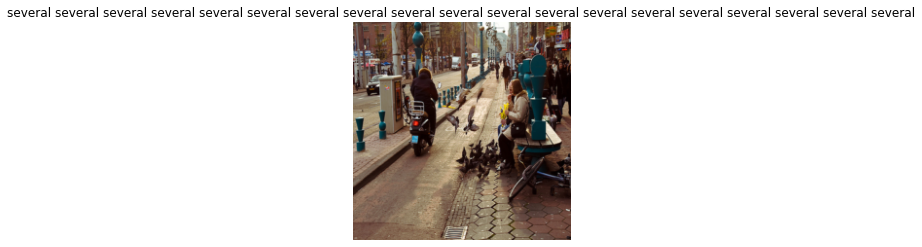

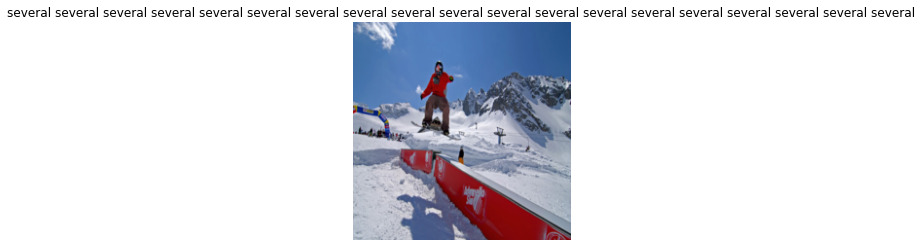

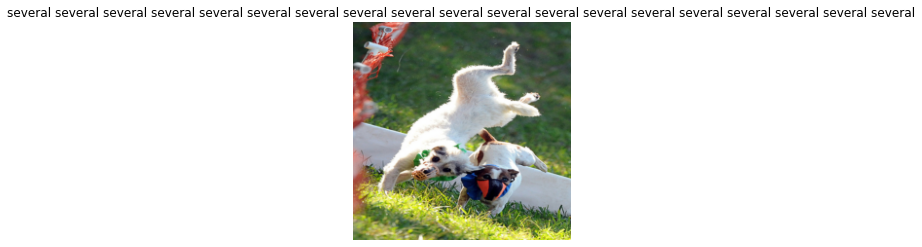

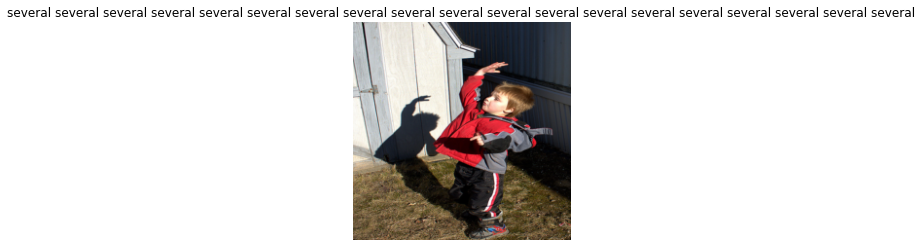

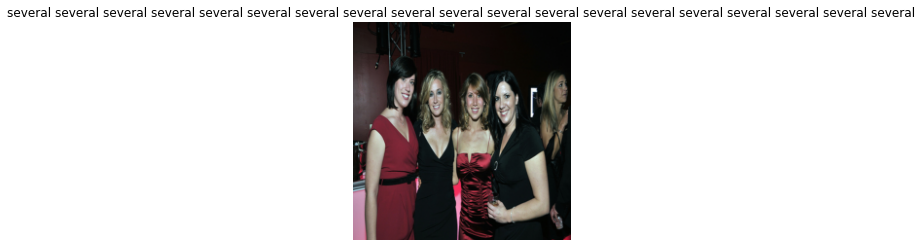

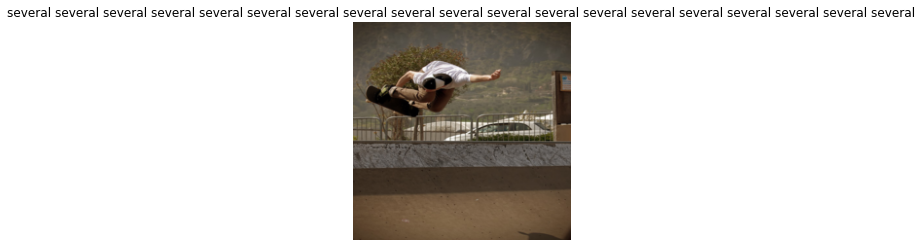

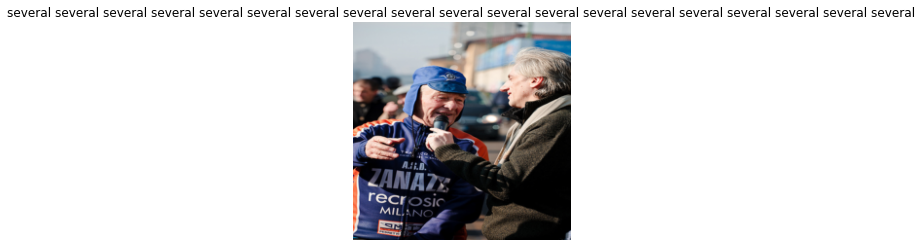

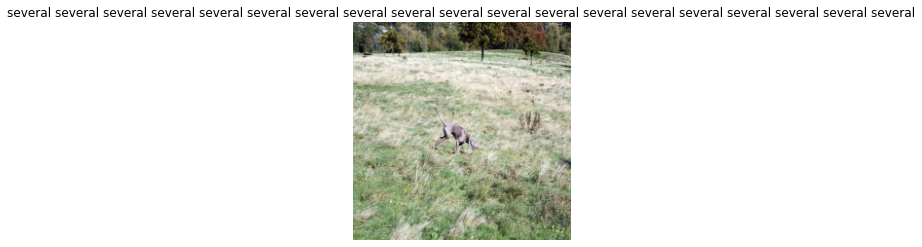

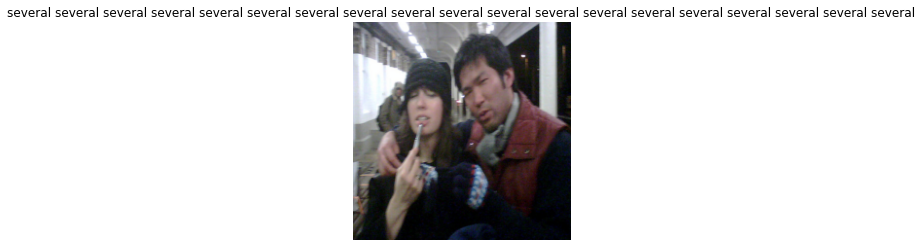

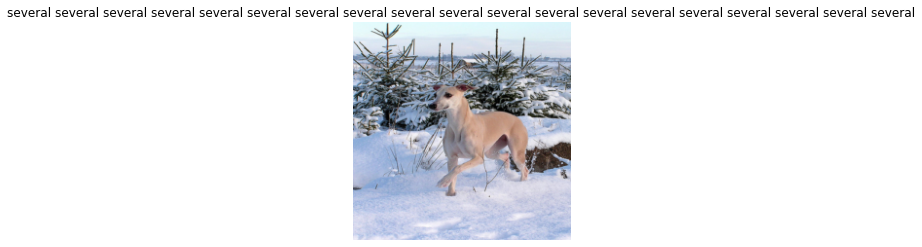

In [ ]:
  for i, (image, captions) in enumerate(iter(testloader)):
    if i <10:
        image,_ = image.to(device),captions.to(device)

        #features = model.encoder(img.to(device))
        #caps = model.captionig(features.unsqueeze(0), vocabulary = dataset.vocab)

        caps = model.captionig(image.to(device), vocabulary = dataset.vocab)
        #caption = ' '.join(caps)
        cap_p ,img_p = imshow(image[0].cpu(), caps)
        plt.imshow(img_p)
        if cap_p is not None:
          plt.title(cap_p)
        plt.axis('off')
        plt.pause(0.001)  # pause a bit so that plots are updated

# Resnet Trainig layer + bidirectal LSTM

In [ ]:
import torch.optim as optim

model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
loss_data_4 = []

for epoch in range(10): 
    running_loss = 0.0  
    for i, (image, captions) in enumerate(iter(trainloader)):
        model.train()
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        running_loss += loss.item()

        #scheduler.step()
    
    loss_data_4.append(running_loss/i)    
    print('epoch %d : loss: %.3f ' %(epoch + 1, running_loss/i ))
            
            

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 : loss: 2.315 
epoch 2 : loss: 0.878 
epoch 3 : loss: 0.465 
epoch 4 : loss: 0.262 
epoch 5 : loss: 0.150 
epoch 6 : loss: 0.084 
epoch 7 : loss: 0.046 
epoch 8 : loss: 0.024 
epoch 9 : loss: 0.012 
epoch 10 : loss: 0.006 


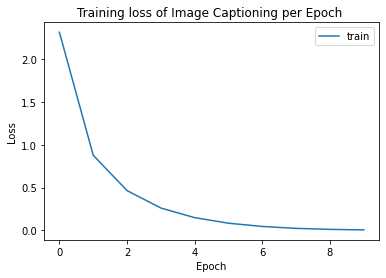

In [ ]:
plt.plot(loss_data_4 )
plt.title('Training loss of Image Captioning per Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train']);

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


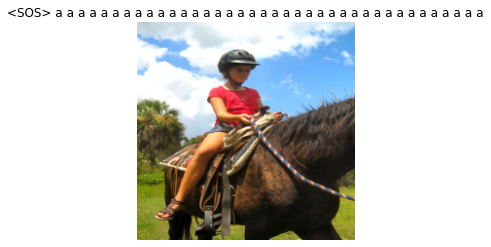

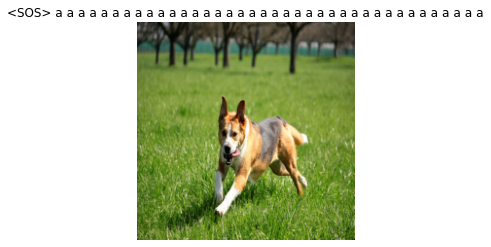

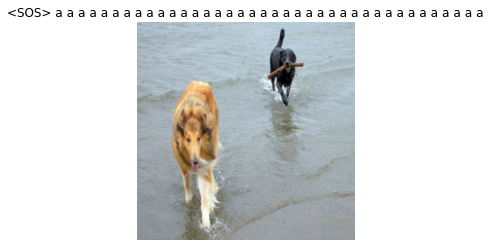

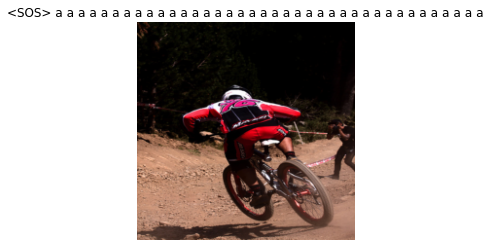

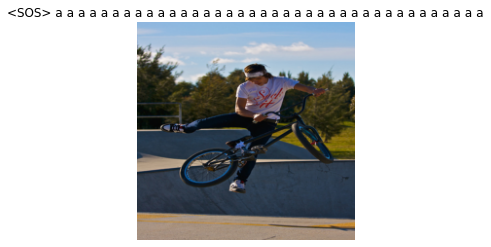

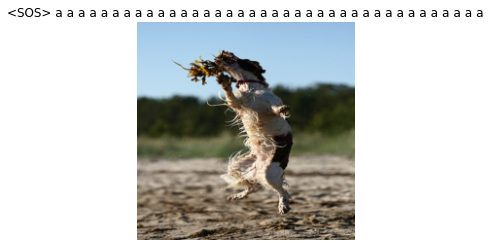

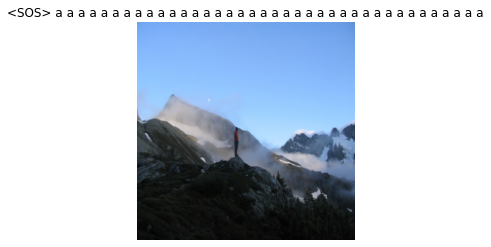

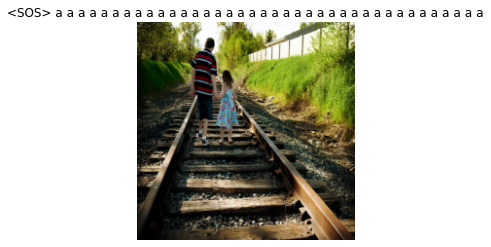

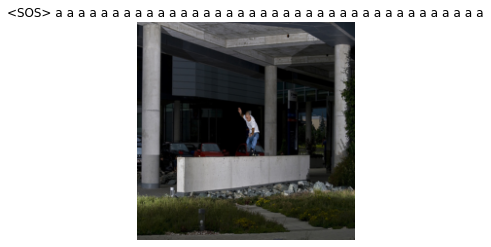

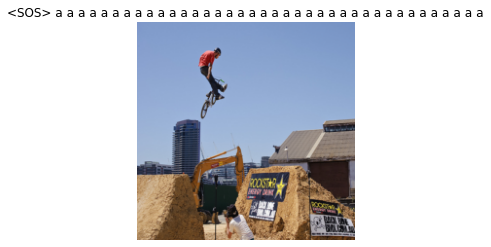

In [ ]:
  for i, (image, captions) in enumerate(iter(testloader)):
    if i <10:
        image,_ = image.to(device),captions.to(device)

        #features = model.encoder(img.to(device))
        #caps = model.captionig(features.unsqueeze(0), vocabulary = dataset.vocab)

        caps = model.captionig(image.to(device), vocabulary = dataset.vocab)
        #caption = ' '.join(caps)
        cap_p ,img_p = imshow(image[0].cpu(), caps)
        plt.imshow(img_p)
        if cap_p is not None:
          plt.title(cap_p)
        plt.axis('off')
        plt.pause(0.001)  # pause a bit so that plots are updated